Для функции заданной таблично
вычислить значение определенного интеграла методом трапеций, сделать уточнение результата по правилу Рунге. Сравнить уточненный результат с результатом вычислений по формуле Симпсона



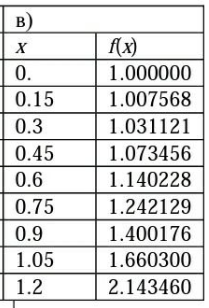

In [27]:
import numpy as np

x = np.array([0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2])
y = np.array([1.000000, 1.007568, 1.031121, 1.073456, 1.140228, 1.242129, 1.400176, 1.660300, 2.143460])

def trapezoidal_rule(x, y):
    n = len(x) - 1
    integral = 0
    for i in range(n):
        h = x[i+1] - x[i]  
        integral += (h/2) * (y[i+1] + y[i])
    return integral

def simpson_rule(x, y):
    n = len(x) - 1
    integral = 0
    for i in range(n // 2):
        k = 2*i
        h = x[k+1] - x[k]  # Шаг
        integral += (h/3) * (y[k] + 4*y[k+1] + y[k+2])
    return integral


trap_result_h = trapezoidal_rule(x, y)
trap_result_2h = trapezoidal_rule(x[::2], y[::2])
trap_result_rung = trap_result_h + (trap_result_h - trap_result_2h) / (2**2-1)

simpson_result = simpson_rule(x, y)

print(f"Метод трапеций: {trap_result_h:.6f}")
print(f"Уточненный результат (Рунге): {trap_result_rung:.6f}")
print(f"Метод Симпсона: {simpson_result:.6f}")

print(f"Разница Рунге и Симпсона: : {abs(trap_result_rung-simpson_result):.6f}")

Метод трапеций: 1.519006
Уточненный результат (Рунге): 1.511016
Метод Симпсона: 1.511016
Разница Рунге и Симпсона: : 0.000000


*Дополнительно 
Попробуйте взять интеграл от быстро осциллирующей функции 



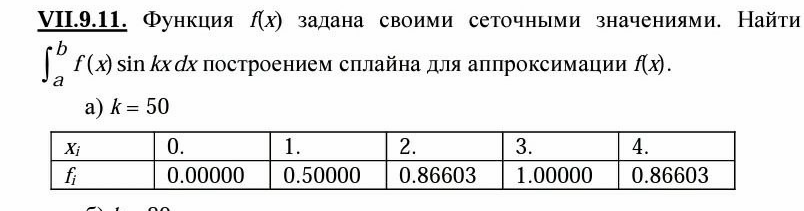

Интеграл от произведения f(x)sin(50x) (трапеция): -0.008348


/home/gukas/Documents/comp_mat/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


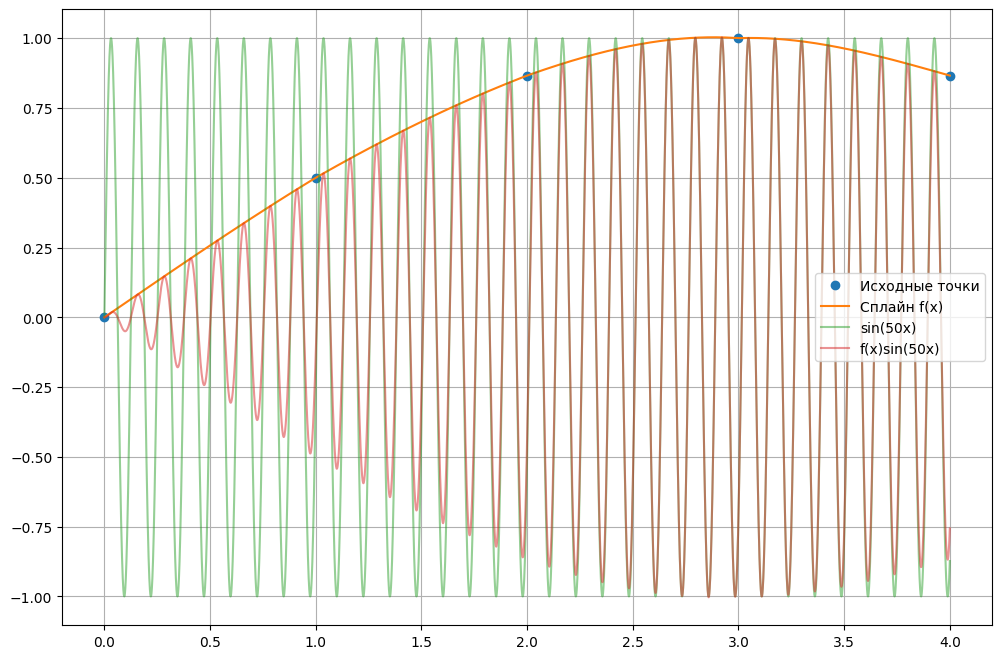

In [31]:
import matplotlib.pyplot as plt 

x = np.array([0., 1., 2., 3., 4.])
y = np.array([0., 0.5, 0.86603, 1., 0.86603])
def cubic_spline_coefficients(x, y):
    n = len(x) - 1
    h = np.diff(x) 
    b = np.diff(y) / h  

    A = np.zeros((n + 1, n + 1))
    rhs = np.zeros(n + 1)

    for i in range(1, n):
        A[i, i - 1] = -h[i - 1]
        A[i, i] = (h[i - 1] + h[i])
        A[i, i + 1] =  h[i]
        rhs[i] = 3 * (b[i] - b[i - 1])

    A[0, 0] = 0
    A[n, n] = 0

    n = len(rhs)
    x = np.zeros(n)  
    r = rhs - A @ x  
    r_tilde = r.copy()  
    p = r.copy()
    p_tilde = r_tilde.copy()
    
    eps = 1e-10  
    max_iter = 1000  
    
    for i in range(max_iter):
        alpha = np.dot(r, r_tilde) / np.dot(A @ p, p_tilde)
        x = x + alpha * p
        r_next = r - alpha * (A @ p)
        r_tilde_next = r_tilde - alpha * (A.T @ p_tilde)
        
        beta = np.dot(r_next, r_tilde_next) / np.dot(r, r_tilde)
        p = r_next + beta * p
        p_tilde = r_tilde_next + beta * p_tilde
        
        if np.linalg.norm(r_next) < eps:
            break
            
        r = r_next
        r_tilde = r_tilde_next
    
    m = x

    return m, h

def cubic_spline_interpolate(x, y, m, h, x_new):
    n = len(x) - 1
    result = np.zeros_like(x_new)

    for k, xk in enumerate(x_new):
        if xk < x[0]:  # Экстраполяция влево
            # Используем первый сплайн
            i = 0
            xi, xi1 = x[i], x[i + 1]
            hi = h[i]
            yi, yi1 = y[i], y[i + 1]
            mi, mi1 = m[i], m[i + 1]
        elif xk > x[-1]:  # Экстраполяция вправо
            # Используем последний сплайн
            i = n - 1
            xi, xi1 = x[i], x[i + 1]
            hi = h[i]
            yi, yi1 = y[i], y[i + 1]
            mi, mi1 = m[i], m[i + 1]
        else:  # Интерполяция
            for i in range(n):
                if x[i] <= xk <= x[i + 1]:
                    xi, xi1 = x[i], x[i + 1]
                    hi = h[i]
                    yi, yi1 = y[i], y[i + 1]
                    mi, mi1 = m[i], m[i + 1]
                    break

        result[k] = (
            mi * (xi1 - xk)**3 / (6 * hi) +
            mi1 * (xk - xi)**3 / (6 * hi) +
            (yi / hi - mi * hi / 6) * (xi1 - xk) +
            (yi1 / hi - mi1 * hi / 6) * (xk - xi)
        )

    return result

m, h = cubic_spline_coefficients(x, y)
x_new = np.linspace(0, 4, 1000000)
y_spline = cubic_spline_interpolate(x, y, m, h, x_new)

k = 50
y_osc = np.sin(k * x_new)

y_product = y_spline * y_osc

trap_result_h = trapezoidal_rule(x_new, y_product)
trap_result_2h = trapezoidal_rule(x_new[::2], y_product[::2])
trap_result_rung = trap_result_h + (trap_result_h - trap_result_2h) / (2**2-1)

print(f"Интеграл от произведения f(x)sin(50x) (трапеция): {trap_result_rung:.6f}")
plt.figure(figsize=(12, 8))
plt.plot(x, y, 'o', label='Исходные точки')
plt.plot(x_new, y_spline, label='Сплайн f(x)')
plt.plot(x_new, y_osc, label='sin(50x)', alpha=0.5)
plt.plot(x_new, y_product, label='f(x)sin(50x)', alpha=0.5)
plt.legend()
plt.grid(True)
plt.show()


